In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import yaml, textwrap

In [3]:
import laserfields
from laserfields import make_laser_field, GaussianLaserField, SinExpLaserField, LinearFlatTopLaserField, Linear2FlatTopLaserField, InterpolatingLaserField
from laserfields import au_as

# Simple example of the `LaserField` constructor
For the accepted parameters and conventions, check the documentation of the Fortran [laserfields library](https://github.com/jfeist/laserfields).

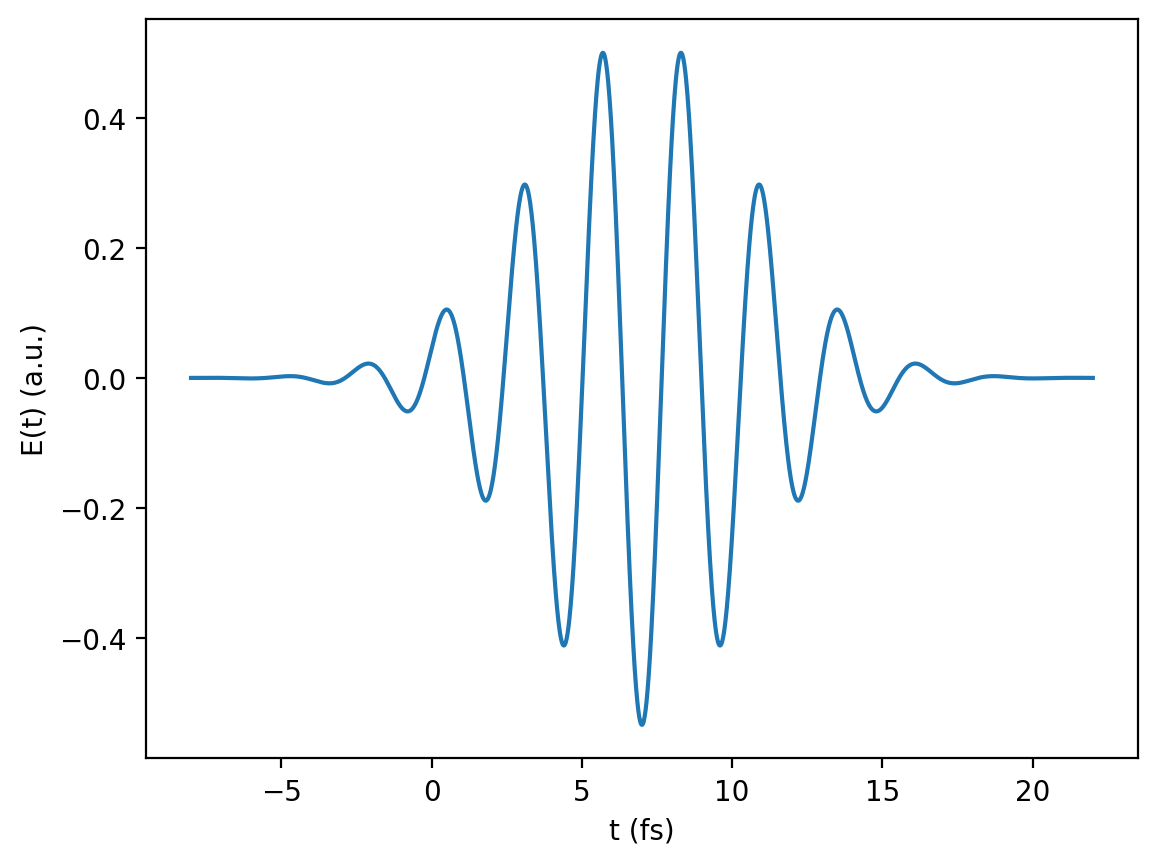

In [4]:
lf = make_laser_field(form="gaussianI", is_vecpot=True, duration_as=6000,
                      lambda_nm=800, intensity_Wcm2=1e16, peak_time_as=7000.)
ts = np.linspace(-8000,22000,2001)*au_as
plt.plot(ts/au_as*1e-3,lf(ts))
plt.xlabel("t (fs)")
plt.ylabel("E(t) (a.u.)");

In [5]:
general_args = dict(is_vecpot=True,E0=1.5,ω0=0.12,t0=500.,chirp=0.,ϕ0=0.8*np.pi)
test_fields = [
    GaussianLaserField(      **general_args,σ=100.),
    SinExpLaserField(        **general_args,T=800.,exponent=2),
    SinExpLaserField(        **general_args,T=800.,exponent=4),
    SinExpLaserField(        **general_args,T=800.,exponent=7),
    LinearFlatTopLaserField( **general_args,Tflat=400.,Tramp=150),
    Linear2FlatTopLaserField(**general_args,Tflat=400.,Tramp=150),
    InterpolatingLaserField(datafile="laserdat.dat", is_vecpot=True),
    InterpolatingLaserField(datafile="laserdat.dat", is_vecpot=False)
];

/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:724: RuntimeWarning: The number of zeros exceeds mest
  warnings.warn(RuntimeWarning("The number of zeros exceeds mest"))


# Plot the envelopes and fields of the different pulse shapes

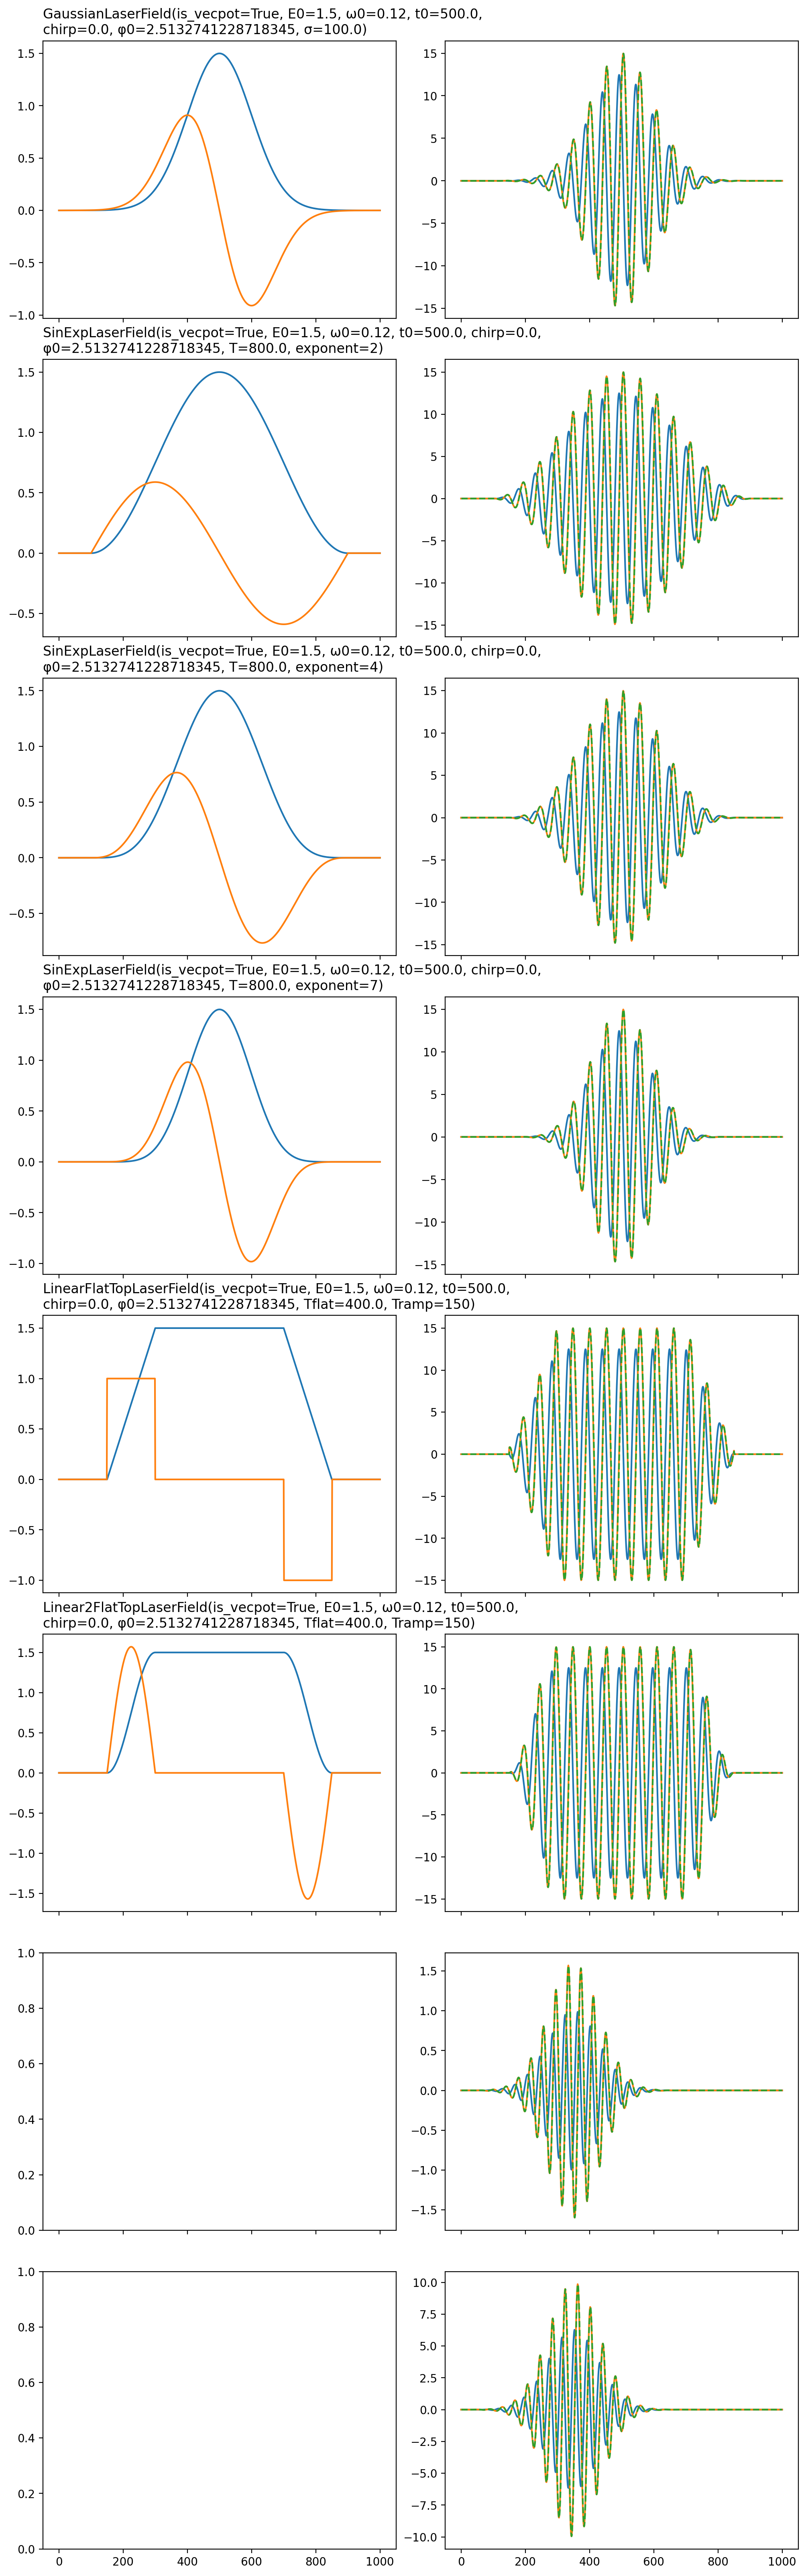

In [6]:
fig,axs = plt.subplots(len(test_fields),2,figsize=(10,4*len(test_fields)),sharex=True)
ts = np.linspace(0,1000,1001)
for (lf,ax) in zip(test_fields,axs):
    try:
        env, envpr = lf.envelope(ts-lf.t0)
        ax[0].set_title(textwrap.fill(str(lf)),loc="left",fontsize=12)
        ax[0].plot(ts,env)
        ax[0].plot(ts,       100*envpr)
        ax[0].plot(ts[2:end],100*np.diff(env)/np.diff(ts),"--")
    except:
        pass
    E = lf(ts)
    A = lf.A(ts)
    ax[1].plot(ts,A)
    ax[1].plot(ts,10*E)
    ax[1].plot(ts[1:],10*-np.diff(A)/np.diff(ts),"--")
fig.tight_layout(pad=0.5)

# Compare the analytical Fourier transforms with numerical ones

In [7]:
test_fields_fourier = []
for lf in test_fields:
    try:
        lf.E_fourier(1.)
        test_fields_fourier.append(lf)
    except:
        pass

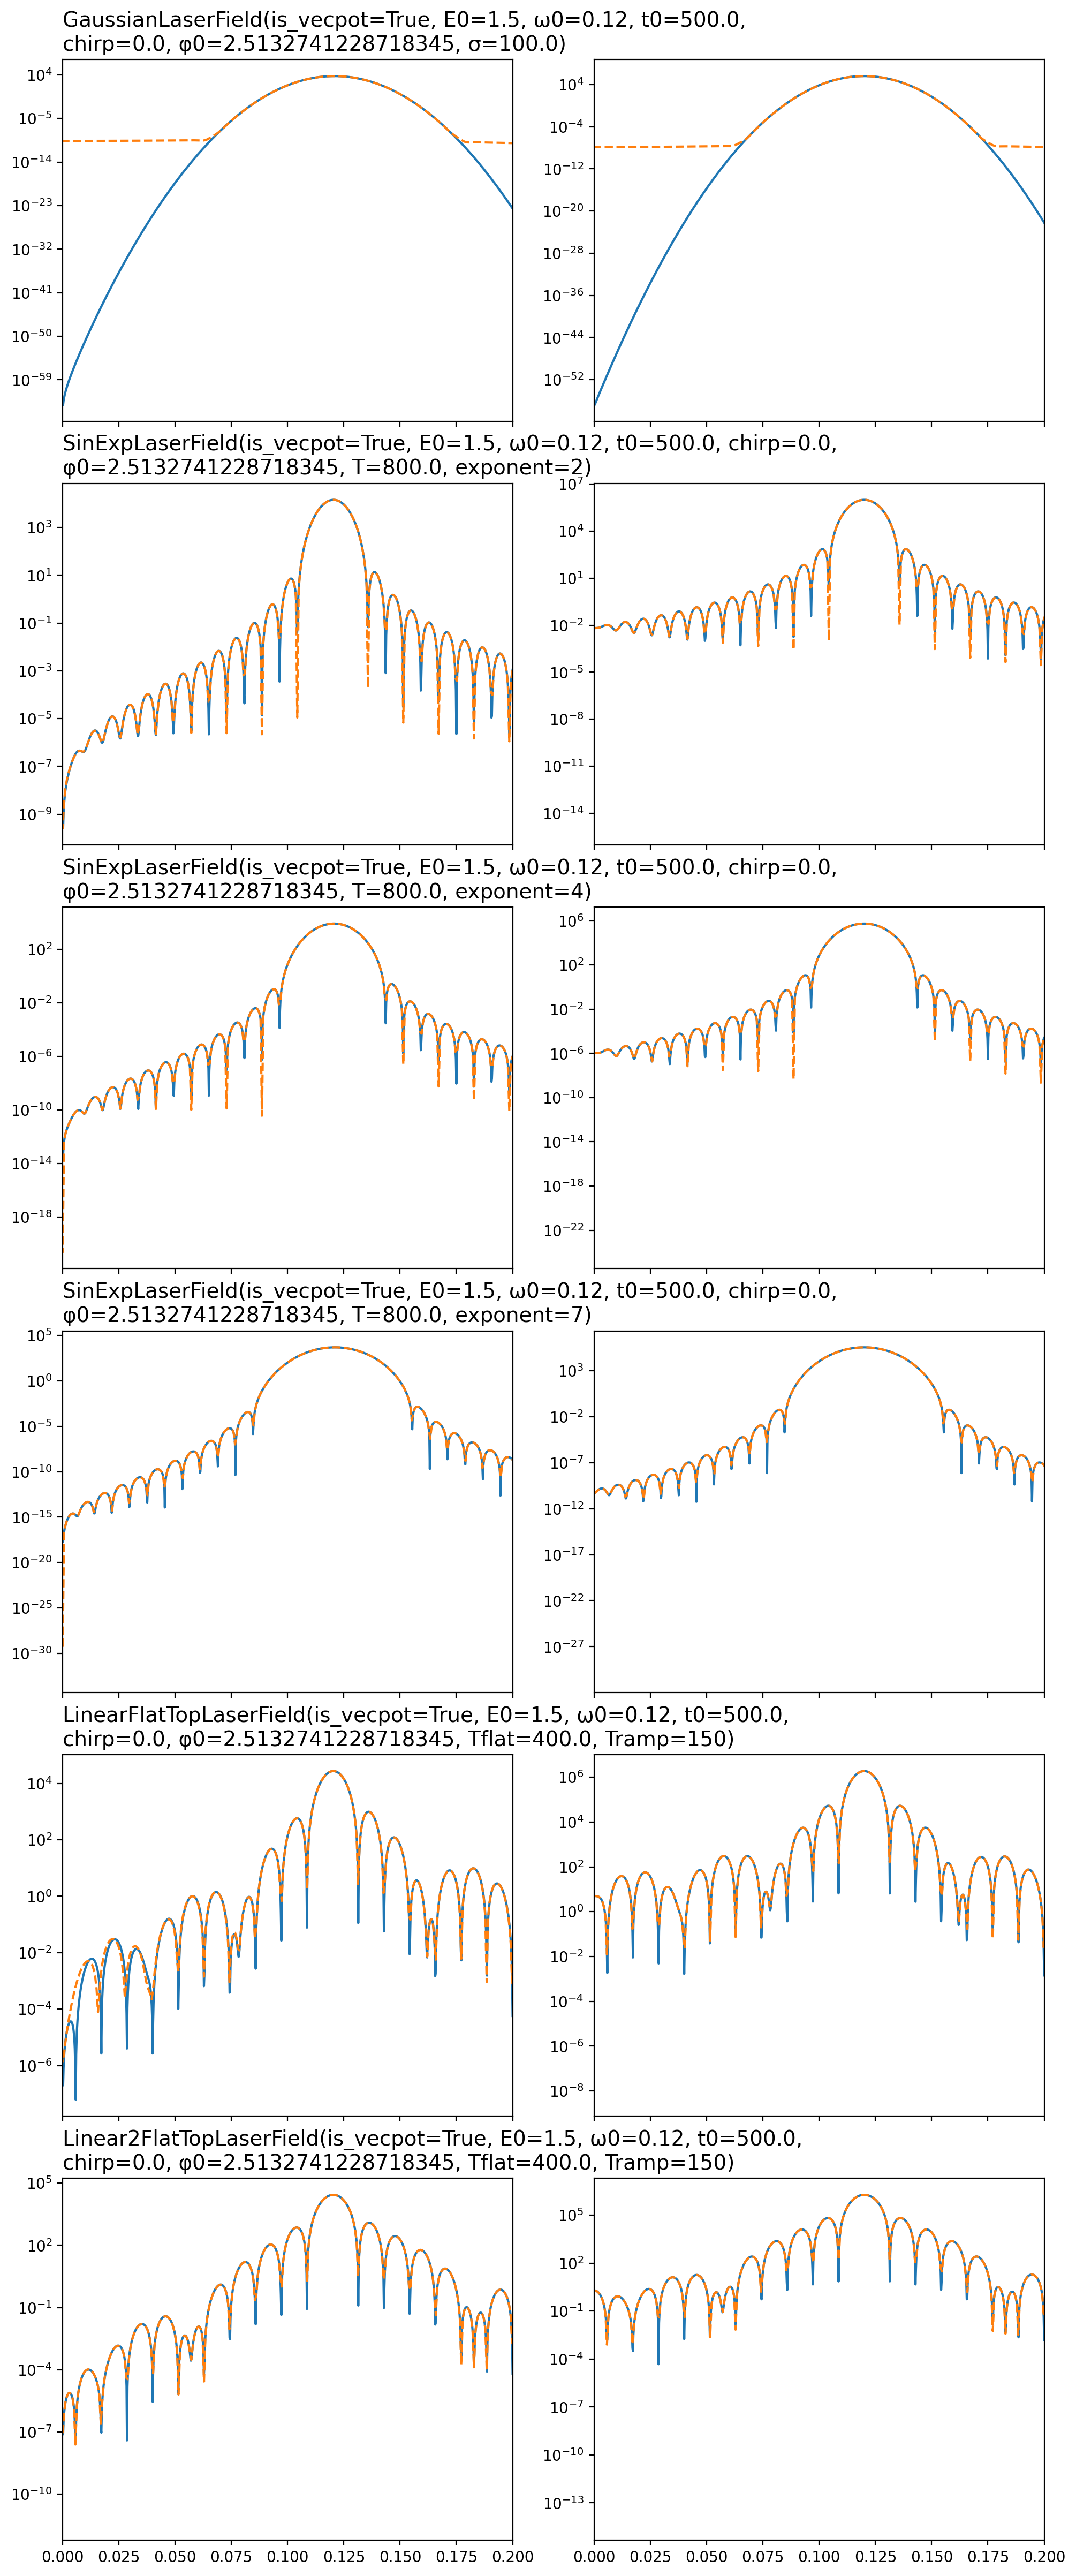

In [8]:
fig,axs = plt.subplots(len(test_fields_fourier),2,figsize=(10,4*len(test_fields_fourier)),sharex=True)
ts = np.linspace(0,10000,10001)
ωs = np.linspace(0,0.2,1001)[1:]
for (lf,ax) in zip(test_fields,axs):
    EF = lf.E_fourier(ωs)
    AF = lf.A_fourier(ωs)
    E = lf.E(ts)
    A = lf.A(ts)
    ωs2 = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(ts),1/(ts[1]-ts[0])))
    fftfac = np.sqrt((ts[1]-ts[0])/(2*np.pi))
    EF2 = fftfac * np.fft.fftshift(np.fft.fft(E))
    AF2 = fftfac * np.fft.fftshift(np.fft.fft(A))
    ax[0].set_title(textwrap.fill(str(lf)),loc="left",fontsize=14)
    ax[0].plot(ωs,abs(EF)**2)
    ax[0].plot(ωs2,abs(EF2)**2,"--")
    ax[1].plot(ωs,abs(AF)**2)
    ax[1].plot(ωs2,abs(AF2)**2,"--")
    ax[0].set_yscale("log")
    ax[1].set_yscale("log")
axs[0,0].set_xlim(0,0.2)
fig.tight_layout(pad=0.5)

# Show a chirped pulse

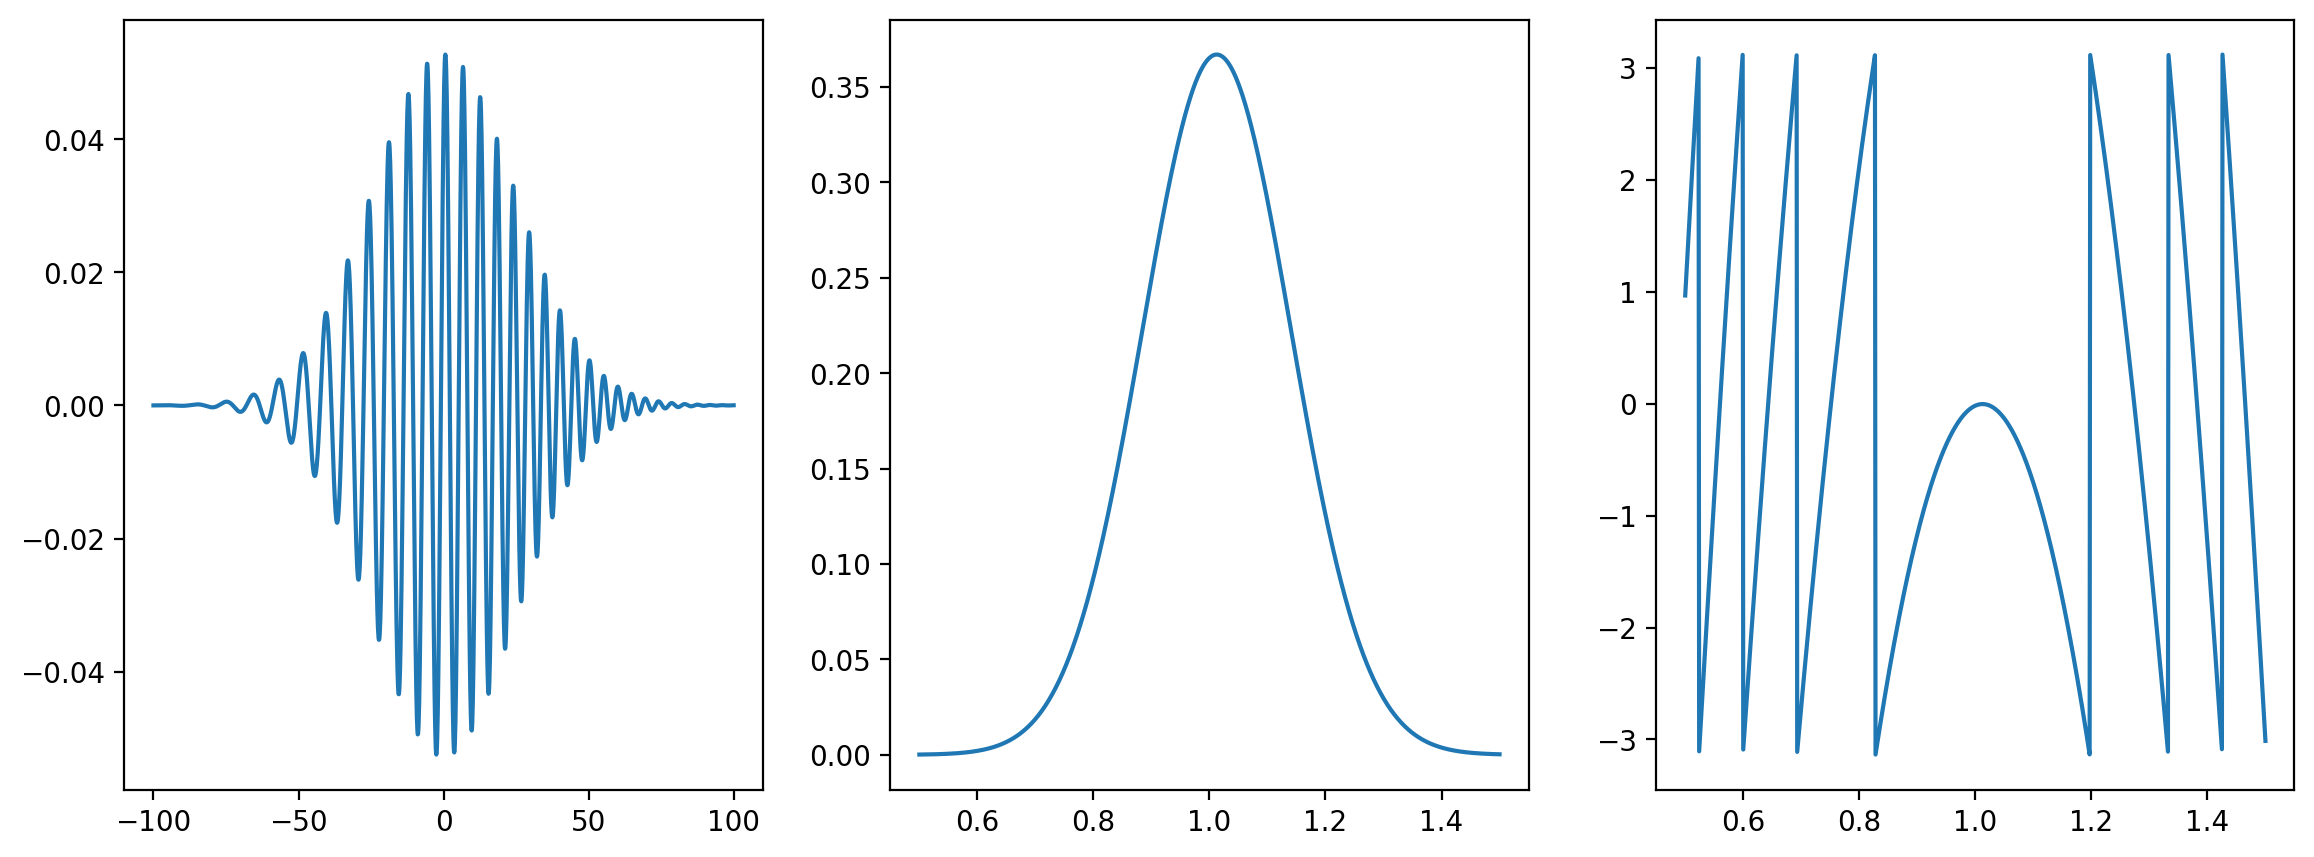

In [9]:
lf = make_laser_field(form="gaussianI",is_vecpot=True,intensity_Wcm2=1e14,lambda_nm=45.,
                      peak_time_as=0,duration_as=1000.,ϕ0=0.3*np.pi,linear_chirp_rate_w0as=1e-4)
ts = np.linspace(-100,100,2001)
fig, axs = plt.subplots(1,3,figsize=(14,5))
axs[0].plot(ts,lf.A(ts));
ωs = np.linspace(0.5,1.5,1001)
axs[1].plot(ωs,abs(lf.A_fourier(ωs)))
axs[2].plot(ωs,np.angle(lf.A_fourier(ωs)));

# Example of using a YAML configuration file to define the laser fields

In [10]:
with open("test.yaml","w") as f:
    f.write("""
laser_fields:
- form: gaussianI
  is_vecpot: true
  intensity_Wcm2: 1.e+14
  duration_as: 700.
  peak_time_as: 2000.
  lambda_nm: 50.
  phase_pi: -0.5
  linear_chirp_rate_w0as: 3.e-4
- form: linear2
  is_vecpot: true
  intensity_Wcm2: 2.e+14
  duration_as: 2000.
  rampon_as: 500
  peak_time_as: 1700.
  lambda_nm: 30.
  phase_pi: 0
  linear_chirp_rate_w0as: 0
""")

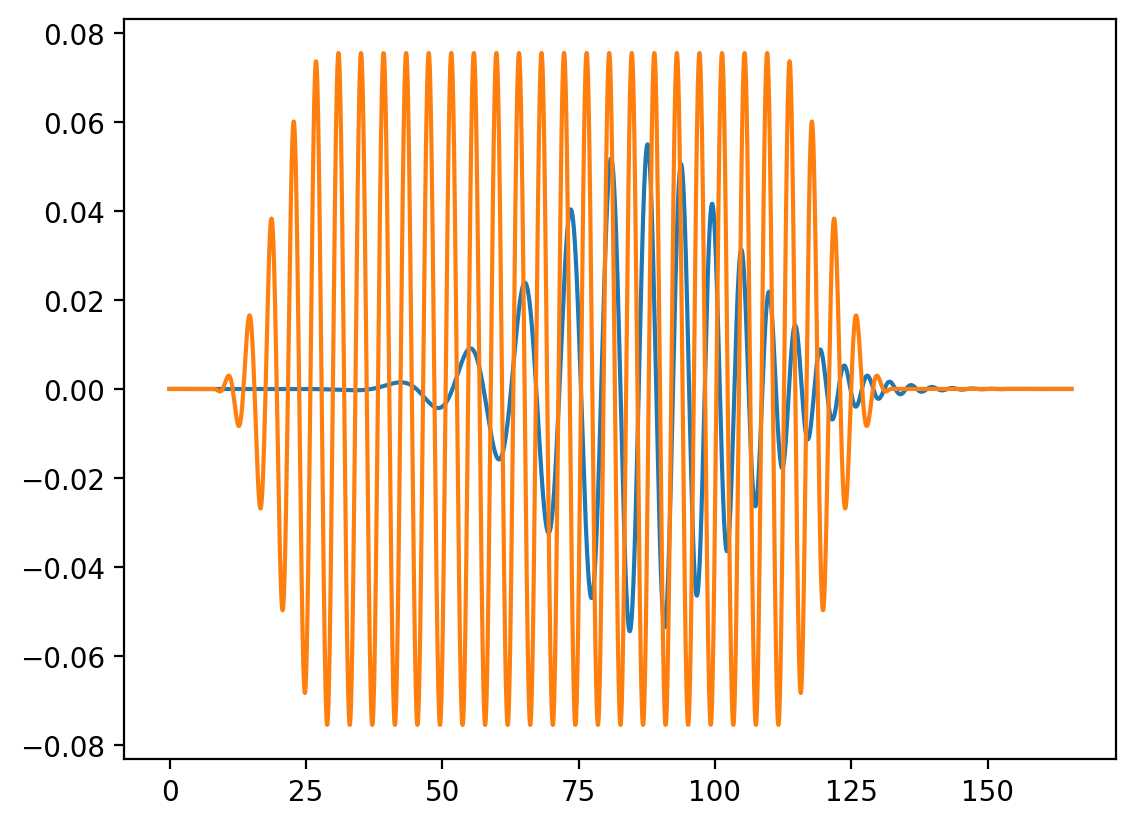

In [11]:
with open("test.yaml","r") as f:
    s = yaml.safe_load(f)
lfs = [make_laser_field(**l) for l in s["laser_fields"]]
ts = np.linspace(0,4000*au_as,4001)
for lf in lfs:
    plt.plot(ts,lf(ts))